In [1]:
import sys
sys.path.append("crypto-volatility-lab")

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from crypto_volatility_lab.modeling import LSTMGRUPipeline, TCNNPipeline
from crypto_volatility_lab.data_construction import CryptoScraper, FeaturesCreator, TimeSeriesCreator
from crypto_volatility_lab.portfolio_optimization.portfolioConstructor import PortfolioConstructor
import pandas as pd

In [2]:
currency_list = ['BTC-USD', 'ETH-USD', 'LTC-USD']
test_start_date = datetime.strptime('2023-01-01', "%Y-%m-%d")

# Récupération des données

On va scraper les données de Yahoo Finance. L'objet CryptoScraper nous permet de réaliser cela. L'objet prend par défaut le maximum de l'historique jusqu'à la date d'aujourd'hui.

In [3]:
crypto_scraper = CryptoScraper()

In [4]:
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')
ethereum_data = crypto_scraper.get_data_for_currency('ETH-USD')
litecoin_data = crypto_scraper.get_data_for_currency('LTC-USD')

In [5]:
# Exemple de données
bitcoin_data.head()

,Date,Open,High,Low,Close,Adj,Volume
0,2025-01-23,103654.81,104447.12,101259.08,104447.12,104447.12,66477785088
1,2025-01-22,106136.38,106294.34,103360.27,103653.07,103653.07,53878181052
2,2025-01-21,102052.58,107180.92,100103.95,106146.27,106146.27,88733878242
3,2025-01-20,101083.75,109114.88,99471.36,102016.66,102016.66,126279678351
4,2025-01-19,104411.29,106299.80,99570.53,101089.61,101089.61,76789928525


# Création des time series

In [6]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
bitcoin_data["Log Returns"] = ts_creator.create_log_return_time_series()
bitcoin_data["Volatility"] = ts_creator.create_volatility_time_series()

ts_creator = TimeSeriesCreator(data=ethereum_data, date_column_name='Date', value_column_name='Close')
ethereum_data["Log Returns"] = ts_creator.create_log_return_time_series()
ethereum_data["Volatility"] = ts_creator.create_volatility_time_series()

ts_creator = TimeSeriesCreator(data=litecoin_data, date_column_name='Date', value_column_name='Close')
litecoin_data["Log Returns"] = ts_creator.create_log_return_time_series()
litecoin_data["Volatility"] = ts_creator.create_volatility_time_series()

# Exemple de données
bitcoin_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
3781,2014-09-17,465.86,468.17,452.42,457.33,457.33,21056800,NaN,NaN
3780,2014-09-18,456.86,456.86,413.10,424.44,424.44,34483200,-0.074635,NaN
3779,2014-09-19,424.10,427.83,384.53,394.80,394.80,37919700,-0.072391,NaN
3778,2014-09-20,394.67,423.30,389.88,408.90,408.90,36863600,0.035091,NaN
3777,2014-09-21,408.08,412.43,393.18,398.82,398.82,26580100,-0.024960,NaN


In [7]:
print(bitcoin_data.shape)
bitcoin_data.dropna(inplace=True)
ethereum_data.dropna(inplace=True)
litecoin_data.dropna(inplace=True)
print(bitcoin_data.shape)

(3782, 9)
(3761, 9)


# Feature engineering

In [9]:
features_creator_bitcoin = FeaturesCreator(data=bitcoin_data)
features_creator_ethereum = FeaturesCreator(data=ethereum_data)
features_creator_litecoin = FeaturesCreator(data=litecoin_data)

features_creator_bitcoin.create_all_features()
features_creator_ethereum.create_all_features()
features_creator_litecoin.create_all_features()

bitcoin_data = features_creator_bitcoin.transformed_data
ethereum_data = features_creator_ethereum.transformed_data
litecoin_data = features_creator_litecoin.transformed_data

features = features_creator_bitcoin.features_names

# Exemple de données
bitcoin_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility,Weekly Volatility,Monthly Volatility,GARCH Volatility,Log Trading Range,Log Volume Change
3760,2014-10-08,336.12,354.36,327.19,352.94,352.94,54736300,0.048622,0.042931,0.042931,0.042931,0.032957,0.079772,NaN
3759,2014-10-09,352.75,382.73,347.69,365.03,365.03,83641104,0.033681,0.041557,0.042244,0.042244,0.032917,0.096019,0.424008
3758,2014-10-10,364.69,375.07,352.96,361.56,361.56,43665700,-0.009552,0.038797,0.041095,0.041095,0.031511,0.060758,-0.649972
3757,2014-10-11,361.36,367.19,355.95,362.30,362.30,13345200,0.002045,0.037781,0.040267,0.040267,0.030004,0.031089,-1.185406
3756,2014-10-12,362.61,379.43,356.14,378.55,378.55,17552800,0.043876,0.038999,0.040013,0.040013,0.031547,0.063346,0.274057


# Train/test split

In [13]:
bitcoin_data.dropna(inplace=True)
ethereum_data.dropna(inplace=True)
litecoin_data.dropna(inplace=True)

In [14]:
bitcoin_train_data = bitcoin_data[bitcoin_data['Date'] < test_start_date]
bitcoin_test_data = bitcoin_data[bitcoin_data['Date'] >= test_start_date]

ethereum_train_data = ethereum_data[ethereum_data['Date'] < test_start_date]
ethereum_test_data = ethereum_data[ethereum_data['Date'] >= test_start_date]

litecoin_train_data = litecoin_data[litecoin_data['Date'] < test_start_date]
litecoin_test_data = litecoin_data[litecoin_data['Date'] >= test_start_date]

# check proportion of test data
print(f"Bitcoin test data proportion: {round(len(bitcoin_test_data) / len(bitcoin_data)*100, 2)}%")
print(f"Ethereum test data proportion: {round(len(ethereum_test_data) / len(ethereum_data)*100, 2)}%")
print(f"Litecoin test data proportion: {round(len(litecoin_test_data) / len(litecoin_data)*100, 2)}%")

Bitcoin test data proportion: 20.05%
Ethereum test data proportion: 28.88%
Litecoin test data proportion: 20.05%


# Prédiction de la volatilité

In [16]:
features = features_creator_bitcoin.features_names

In [17]:
# bitcoin model
bitcoin_pipeline = LSTMGRUPipeline(forecast_horizon=5, epochs=30, batch_size=32, validation_split=0.1, normalize=True)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))

# ethereum model
ethereum_pipeline = LSTMGRUPipeline(forecast_horizon=5, epochs=20, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

# litecoin model
litecoin_pipeline = LSTMGRUPipeline(forecast_horizon=5, epochs=30, batch_size=32, validation_split=0.1, normalize=True)
litecoin_model= litecoin_pipeline.fit(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0237 - val_loss: 0.0024
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - val_loss: 0.0027
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0041 

In [23]:
# Evaluation

# insert data from train for lookback window in the test data
lookback_window = bitcoin_pipeline.lookback
bitcoin_test_data = bitcoin_test_data.reset_index(drop=True)
bitcoin_test_data = pd.concat([bitcoin_train_data.iloc[-lookback_window + 1:], bitcoin_test_data], ignore_index=True)

lookback_window = ethereum_pipeline.lookback
ethereum_test_data = ethereum_test_data.reset_index(drop=True)
ethereum_test_data = pd.concat([ethereum_train_data.iloc[-lookback_window + 1:], ethereum_test_data], ignore_index=True)

lookback_window = litecoin_pipeline.lookback
litecoin_test_data = litecoin_test_data.reset_index(drop=True)
litecoin_test_data = pd.concat([litecoin_train_data.iloc[-lookback_window + 1:], litecoin_test_data], ignore_index=True)

print("Bitcoin")
print("Train")
bitcoin_pipeline.evaluate_metrics(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))
print("Test")
bitcoin_pipeline.evaluate_metrics(bitcoin_test_data[features].values, bitcoin_test_data["Volatility"].values.astype(np.float64))

print("Ethereum")
print("Train")
ethereum_pipeline.evaluate_metrics(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))
print("Test")
ethereum_pipeline.evaluate_metrics(ethereum_test_data[features].values, ethereum_test_data["Volatility"].values.astype(np.float64))

print("Litecoin")
print("Train")
litecoin_pipeline.evaluate_metrics(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))
print("Test")
litecoin_pipeline.evaluate_metrics(litecoin_test_data[features].values, litecoin_test_data["Volatility"].values.astype(np.float64))

Bitcoin
Train

Evaluation Metrics by Time Step:
Time Step MSE            MAE            MAPE (%)       
---------------------------------------------
1         0.0000         0.0027         10.4418        
2         0.0000         0.0030         11.2704        
3         0.0000         0.0035         12.2089        
4         0.0000         0.0038         13.2549        
5         0.0000         0.0041         13.9224        

Overall Evaluation Metrics:
---------------------------------------------
Metric              Value          
Overall MSE         0.0000         
Overall MAE         0.0034         
Overall MAPE (%)    12.2197        
Test

Evaluation Metrics by Time Step:
Time Step MSE            MAE            MAPE (%)       
---------------------------------------------
1         0.0000         0.0017         8.8949         
2         0.0000         0.0020         9.7595         
3         0.0000         0.0021         10.1978        
4         0.0000         0.0024         11

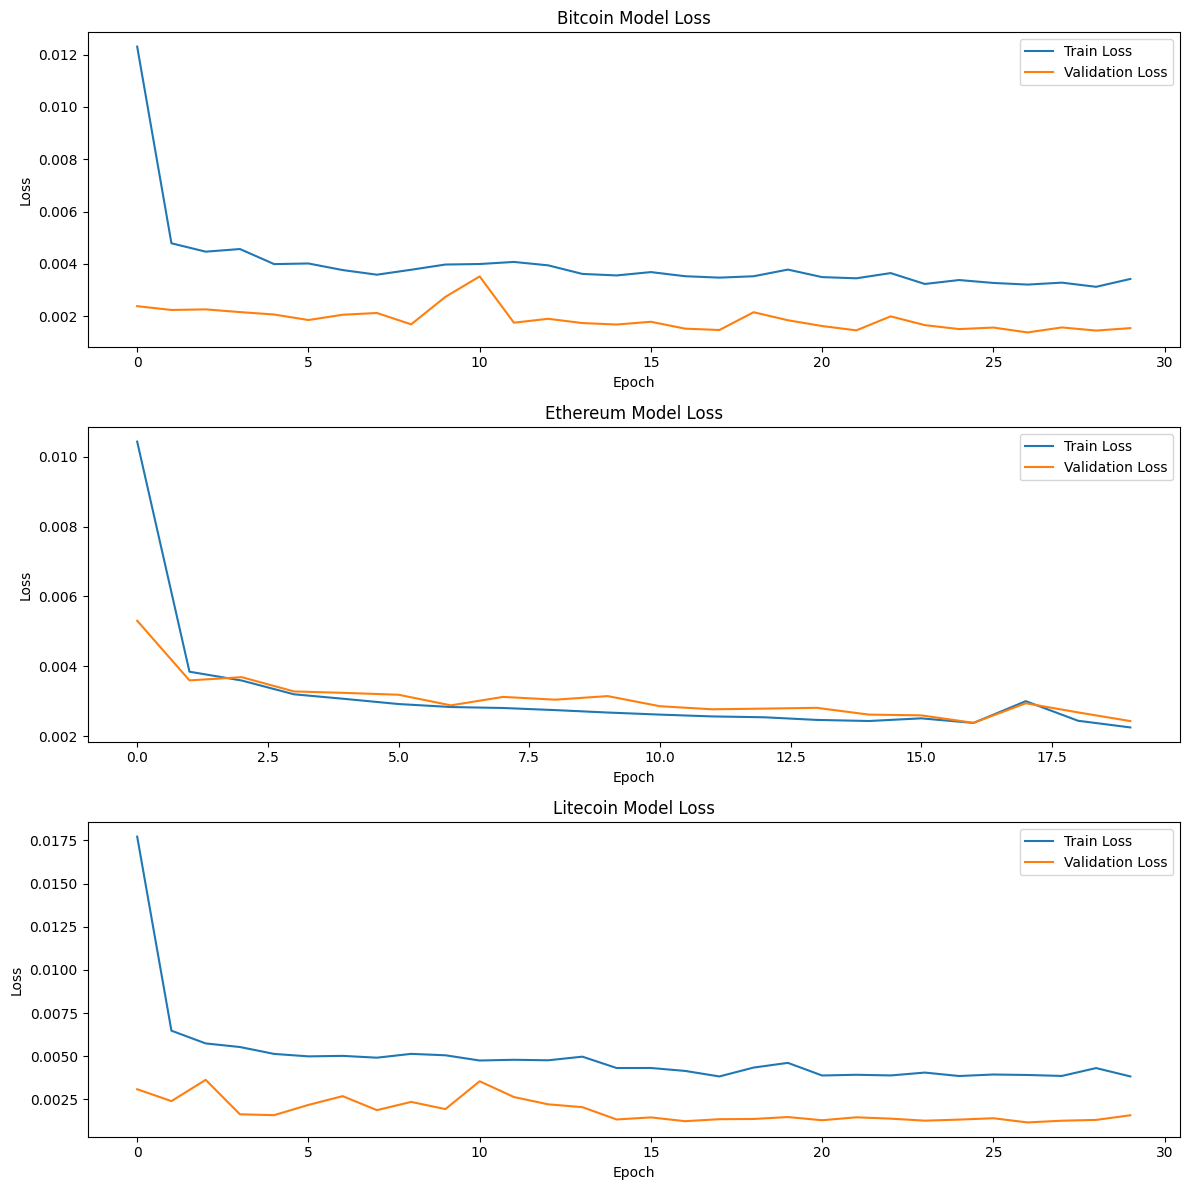

In [24]:
# Plot loss history of models
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

bitcoin_history = bitcoin_pipeline.get_history()
ethereum_history = ethereum_pipeline.get_history()
litecoin_history = litecoin_pipeline.get_history()

ax[0].plot(bitcoin_history['loss'], label='Train Loss')
ax[0].plot(bitcoin_history['val_loss'], label='Validation Loss')
ax[0].set_title('Bitcoin Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(ethereum_history['loss'], label='Train Loss')
ax[1].plot(ethereum_history['val_loss'], label='Validation Loss')
ax[1].set_title('Ethereum Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

ax[2].plot(litecoin_history['loss'], label='Train Loss')
ax[2].plot(litecoin_history['val_loss'], label='Validation Loss')
ax[2].set_title('Litecoin Model Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


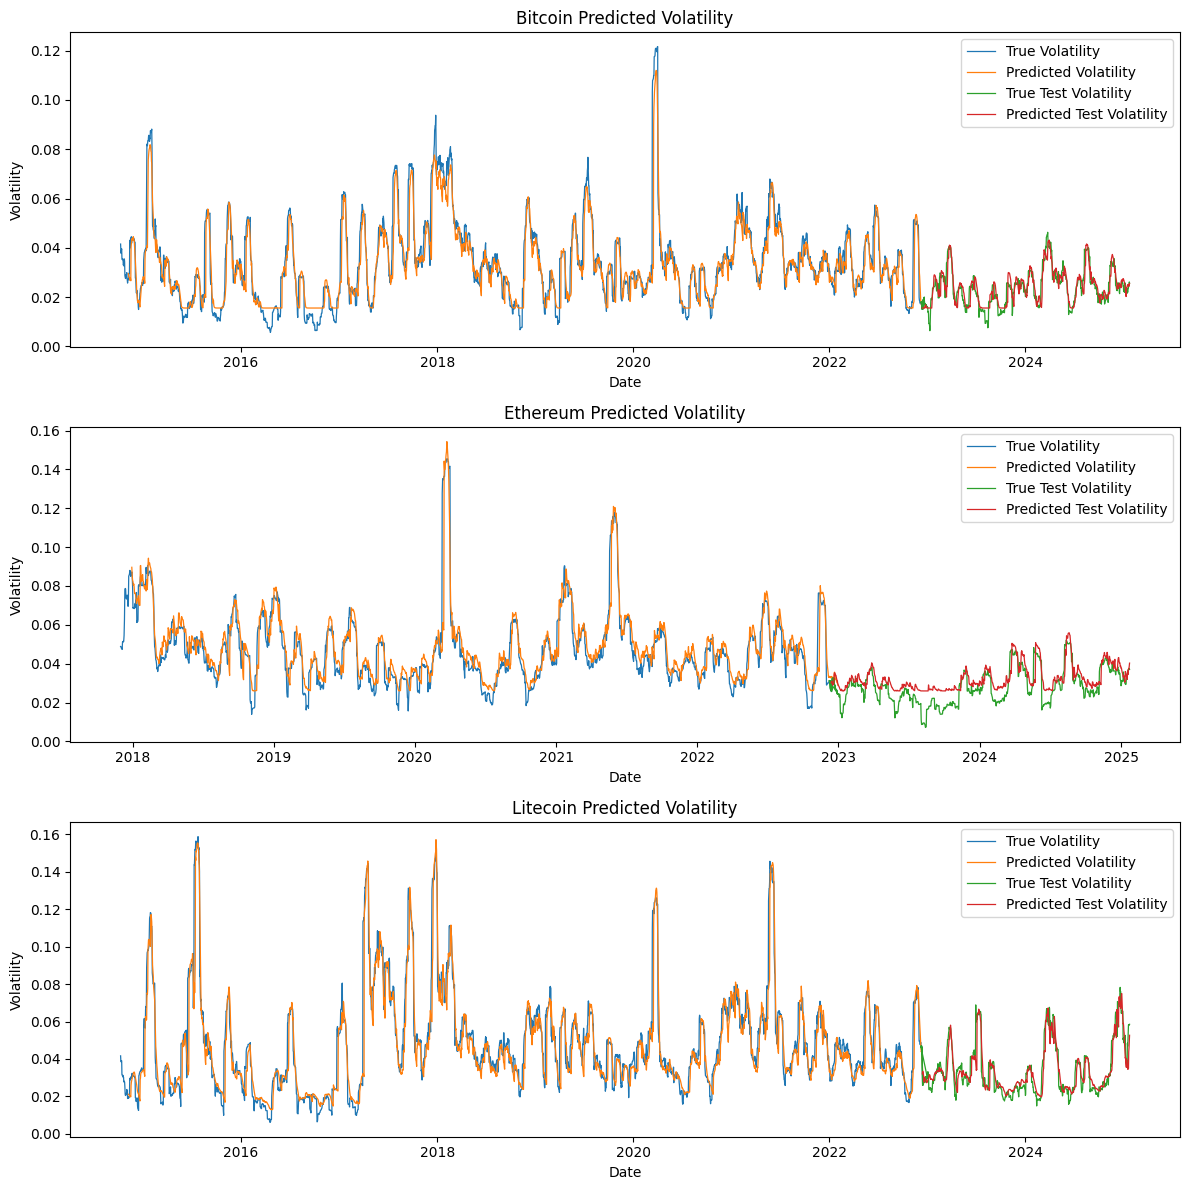

In [25]:
def predict_and_plot(pipeline, train_data, test_data, ax, title):
    # keep only t+5 predictions
    y_pred_train = pipeline.predict(train_data[features].values)[:, 4]
    y_pred_test = pipeline.predict(test_data[features].values)[:, 4]
    
    ax.plot(train_data["Date"], train_data["Volatility"], label="True Volatility", linewidth=0.9)
    ax.plot(train_data["Date"][-len(y_pred_train):], y_pred_train, label="Predicted Volatility",  linewidth=0.9)
    ax.plot(test_data["Date"], test_data["Volatility"], label="True Test Volatility",  linewidth=0.9)
    ax.plot(test_data["Date"][-len(y_pred_test):], y_pred_test, label="Predicted Test Volatility",  linewidth=0.9)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.legend()
    return y_pred_train, y_pred_test

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

y_pred_bitcoin_train, y_pred_bitcoin_test = predict_and_plot(bitcoin_pipeline, bitcoin_train_data, bitcoin_test_data, ax[0], "Bitcoin Predicted Volatility")
y_pred_ethereum_train, y_pred_ethereum_test = predict_and_plot(ethereum_pipeline, ethereum_train_data, ethereum_test_data, ax[1], "Ethereum Predicted Volatility")
y_pred_litecoin_train, y_pred_litecoin_test = predict_and_plot(litecoin_pipeline, litecoin_train_data, litecoin_test_data, ax[2], "Litecoin Predicted Volatility")

plt.tight_layout()
plt.show()